In [1]:
%pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json 
from urllib.parse import unquote
from collections import defaultdict
from rapidfuzz.process import cdist
import pandas as pd
import numpy as np

# アーティストの類似度を確認

## 30MUの同一期間アーティスト及び楽曲とのペアのデータを取り出し

In [7]:
track_dict = defaultdict(tuple)

with open( '/home/tamak/master_exp/ThirtyMusic/entities/tracks.idomaar', mode = 'r' ) as f:
    lines = f.readlines()

    for line in lines:
        try:
           entitiy_type, track_id, _, info, extra_info = line.split('\t')
        except:
            print(line)
            for l in line.split():
                print(l)
            break

        
        name = json.loads(info)['name']
        artistname, trackname = name.split('/_/')

        artistname = unquote(artistname.replace('+',' '))
        trackname = unquote(trackname.replace('+',' '))

        if track_id not in track_dict:
            track_dict[ int(track_id) ] = (artistname, trackname)


In [8]:
ThMU_artist = set()
ThMU_dict = defaultdict(list)

with open('30M_dataset/same_duration_data.tsv', mode = 'r') as f:
    lines  = f.readlines()

for line in lines[1:]:
    tmp = []
    data = line.split('\t')

    user_id = data[0]
    session = data[1:]

    tmp.append(user_id)

    for track_id in session:
        artistname, trackname = track_dict[int(track_id)]

    ThMU_artist.add(artistname)
    ThMU_dict[artistname].append(trackname)

## SPDのアーティスト及び楽曲とのペアのデータを取り出し

In [9]:
SPD_artist = set()
SPD_dict = defaultdict(list)

with open('./spotify_playlists_dataset/SPD_modified.tsv', mode = 'r') as f:

    lines = f.readlines()

for line in lines[1:]:
    data = line.split('\t,\t')

    if data[1] != '' and data[2] != '':

        artistname, trackname = (data[1],data[2])

        SPD_artist.add( artistname )
        SPD_dict[artistname].append(trackname)

## 類似度チェック

In [6]:
ThMU_table = np.array(list(ThMU_artist), dtype=str)
SPD_table = np.array(list(SPD_artist), dtype=str)

In [7]:
SPD_table

array(['Hard Driver & MC DL', 'Mojave 3', 'Torbjørn & Helfner', ...,
       'Pitbull, TKZee and Dario G', 'Art of Tones', 'Franco Morone'],
      dtype='<U255')

In [8]:
similarity = cdist(ThMU_table[0:1000], SPD_table,workers=-1)

In [9]:
similarity_table = pd.DataFrame({
    '30MU':ThMU_table[0:1000],
    'SPD':SPD_table[similarity.argmax(axis=1)],
    'ratio':(similarity.max(axis=1) / 100).astype(float)
})

similarity_table[ (similarity_table['ratio'] < 1) & (similarity_table['ratio'] > 0.8 )].sort_values('ratio')

,30MU,SPD,ratio
998,Deflate,Desolate,0.800000
238,Mastercastle,Masterblaster,0.800000
241,Hc3,c3,0.800000
270,CG Bros.,DG Bros,0.800000
156,Eric Mouquet,Eric Moe,0.800000
...,...,...,...
332,The Murder Of Rosa Luxemburg,The Murder of Rosa Luxemburg,0.964286
552,"Eli ""Paperboy"" Reed","Eli ""Paperboy"" Reed",0.974359
89,Arty feat. Tania Zygar,Arty feat. Tania Zyga,0.976744
957,Tymon The Transistors,Tymon & The Transistors,0.977778


In [10]:
similarity_table = pd.DataFrame(columns=['30MU', 'SPD', 'ratio'])
similarity_table

,30MU,SPD,ratio


In [11]:
i = 0
dlt = 1000

while(i<len(ThMU_table)):

    if (i+dlt)<len(ThMU_table):

        similarity = cdist(ThMU_table[i:i+dlt], SPD_table,workers=-1)

        try:
            tmp_table = pd.DataFrame({
            '30MU':ThMU_table[ i:i+dlt ],
            'SPD':SPD_table[ similarity.argmax(axis=1) ],
            'ratio':(similarity.max(axis=1) / 100).astype(float)
            })
        except:
            print(i)
            print(len(similarity))
            print(len(SPD_table[ similarity.argmax(axis=1) ]))

    else:
        similarity = cdist(ThMU_table[i:], SPD_table,workers=-1)

        tmp_table = pd.DataFrame({
        '30MU':ThMU_table[ i: ],
        'SPD':SPD_table[ similarity.argmax(axis=1) ],
        'ratio':(similarity.max(axis=1) / 100).astype(float)
        })

    similarity_table = pd.concat([similarity_table, tmp_table])
    i+=dlt

/tmp/ipykernel_19398/462427290.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  similarity_table = pd.concat([similarity_table, tmp_table])


In [12]:
similarity_table

,30MU,SPD,ratio
0,Akeboshi,Akeboshi,1.000000
1,Lowell Pye,Lowell Pye,1.000000
2,cEvin Key / Ken Marshall,cEvin Key / Ken Marshall,1.000000
3,Bobaflex,Bobaflex,1.000000
4,Mojave 3,Mojave 3,1.000000
...,...,...,...
801,Ratu,Ratu,1.000000
802,The Tips,The Tulips,0.888889
803,Diesel King,Denise King,0.818182
804,Punkreas,Punkreas,1.000000


In [19]:
similarity_table.sort_values('ratio').to_csv('artist_pairs.csv', sep = '\t')

## read csv

In [21]:
similarity_table = pd.read_csv('artist_pairs.csv', sep = '\t', usecols=[1,2,3])

In [22]:
similarity_table

,30MU,SPD,ratio
0,არა,Hard Driver & MC DL,0.0
1,長渕剛,Hard Driver & MC DL,0.0
2,효린,Hard Driver & MC DL,0.0
3,凛,Hard Driver & MC DL,0.0
4,･ﾊ･ﾎ,Hard Driver & MC DL,0.0
...,...,...,...
78801,Christian Williams,Christian Williams,1.0
78802,Antero Lindgren,Antero Lindgren,1.0
78803,Mark Mancina,Mark Mancina,1.0
78804,Joey Pastrana,Joey Pastrana,1.0


(array([   55.,    56.,   560.,   651.,  1431.,  2926.,  7561.,  9623.,
         8987., 46956.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

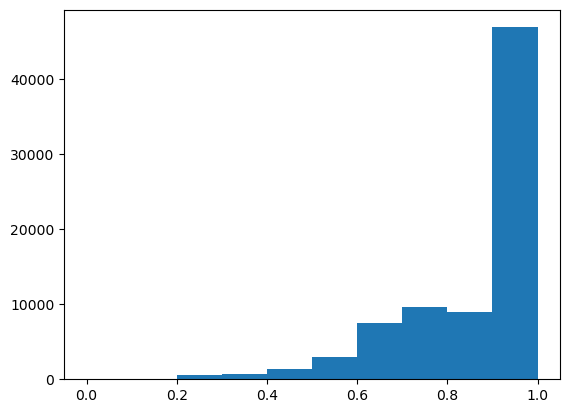

In [23]:
import matplotlib.pyplot as plt

plt.hist(similarity_table['ratio'].to_numpy())

In [24]:
len(similarity_table[  similarity_table['ratio'] > 0.6 ])/len(similarity_table)

0.9279369591147882

Banda União Black	União Black について

In [24]:
ThMU_dict['Banda União Black']

['Been So Long', 'Cris Vacilou', 'African Hot Band']

In [25]:
SPD_dict['União Black']

['Been So Long', 'Melô Do Lula', 'Tudo Azul', "Everyone's A Winner"]

# アーティスト-楽曲について確認

類似あるいは同一アーティスト名に関して，それぞれの持つ楽曲を比較．  
類似度が高ければリストに追加する

In [27]:
similarity_table

,30MU,SPD,ratio
0,არა,Hard Driver & MC DL,0.0
1,長渕剛,Hard Driver & MC DL,0.0
2,효린,Hard Driver & MC DL,0.0
3,凛,Hard Driver & MC DL,0.0
4,･ﾊ･ﾎ,Hard Driver & MC DL,0.0
...,...,...,...
78801,Christian Williams,Christian Williams,1.0
78802,Antero Lindgren,Antero Lindgren,1.0
78803,Mark Mancina,Mark Mancina,1.0
78804,Joey Pastrana,Joey Pastrana,1.0


In [38]:
from tqdm import tqdm

pd.DataFrame(columns=['30MU_artist', '30MU_track', 'SPD_artist', 'SPD_track', 'ratio'])

for _, row in tqdm(similarity_table.iterrows(), total=len(similarity_table)):
    
    ThMU = row['30MU']
    SPD = row['SPD']
    ratio = float(row['ratio'])

    if ratio > 0.6:
        ThMU_tarcks = np.array(ThMU_dict[ThMU])
        SPD_tracks = np.array(SPD_dict[SPD])

        try:
            similarity = cdist(ThMU_tarcks, SPD_tracks,workers=-1)
        except:
            # print(ThMU_tarcks)
            print(ThMU_dict[ThMU])
            print('===========================================')
            # print(SPD_tracks)
            print(SPD_dict[SPD])
            continue

        # try:
        tmp_table = pd.DataFrame({
        '30MU_track':ThMU_tarcks,
        'SPD_track':SPD_tracks[ similarity.argmax(axis=1) ],
        'ratio':(similarity.max(axis=1) / 100).astype(float)
        })
        # except:
        #     print(similarity.shape)
        #     print(similarity.argmax(axis=1))
        #     break

        tmp_table['30MU_artist'] = ThMU
        tmp_table['SPD_artist'] = SPD

        similarity_table = pd.concat([similarity_table, tmp_table])

  1%|          | 6582/562538 [00:25<36:07, 256.46it/s]  


KeyboardInterrupt: 

In [ ]:
similarity_table.to_csv('similar_pairs.csv', sep='\t')